# 基于图的LBSN网络分析

## 参考

- [1] [An Experimental Evaluation of Pointofinterest Recommendation in Locationbased Social Networks（打开思路）](https://www.semanticscholar.org/paper/An-Experimental-Evaluation-of-Point-of-interest-in-Liu-Pham/8c999b9c270340bf57f2113064ab7c0e98710e08?p2df)  
- [2] [Exploiting Geographical Influence for Collaborative Point-of-Interest Recommendation（主文献）](http://www.cse.cuhk.edu.hk/irwin.king.new/_media/presentations/p325.pdf)  
- [3] [Augmenting Collaborative Recommender by Fusing Explicit Social Relationships（计算$L+$）](https://ls13-www.cs.tu-dortmund.de/homepage/RSWEB/papers/Yuan.pdf)  
- [4] [Random-Walk Computation of Similarities between Nodes of a Graph with Application to Collaborative Recommendation（计算$L+$）](https://d1wqtxts1xzle7.cloudfront.net/2136944/5zoa93jb40vzxxq.pdf?1425083454=&response-content-disposition=inline%3B+filename%3DRandom_walk_computation_of_similarities.pdf&Expires=1624010106&Signature=QN7nQr96QUJdXfH2A9E5qlAjVJKzYPslpb52lpgZdniULKKqL351apNIEkDLrirgoYZZQp8x8B3mOYZ1zpELXIFzJitx5FkGVCtYaJjAnQVWFsUjcAoR83TLCjSxeUCY6-aXpAK6kz-O6HoOdc6v2qXnG4l7Ss9-PBXTIPjttRSkucl8cg7Org6IWvfwVqcvVetZzfGf6DZhF92xFuanwwvtW~GGJJmbjxj9mXKNTQx-Lb7rB38bJvw5ZtRhGRRvW2TM-uMm~HiV1Wunp61pSt4WdP5M8xa5aTODsqxy-DYQ0kBcFmo1mzOfuNurTFz~a2sPkN06anQiXegiRSa5hg__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA)  

## 导入必要的包

* 网络处理：[networkx](https://www.osgeo.cn/networkx/)  
* 稀疏矩阵的处理：[scipy.sparse](https://docs.scipy.org/doc/scipy/reference/sparse.html) & [scipy.sparse(CSDN1)](https://blog.csdn.net/qq_33466771/article/details/80304498) & [scipy.sparse(CSDN2)](https://blog.csdn.net/winycg/article/details/80967112)
* 求解稀疏矩阵方程：[cvxopt](http://cvxopt.org/userguide/spsolvers.html?highlight=cholmod#cvxopt.cholmod.linsolve)
* 加速dataframe计算：[dask](https://dask.org/)
* 加速dataframe的apply计算：[swifter](https://github.com/jmcarpenter2/swifter)   

In [1]:
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = 'all' #默认为'last'
from IPython.display import Image  

import pandas as pd
import numpy as np
import networkx as nx
import os
from scipy import sparse
from cvxopt import cholmod, spmatrix, matrix, umfpack
import dask.dataframe as dd
import swifter
import json
from sklearn.utils import shuffle
from math import exp, sqrt
from tqdm import tqdm
import warnings
import gc

warnings.filterwarnings('ignore')

## 原理分析

### 马尔可夫链

#### 马尔可夫性质和马尔可夫过程

**马尔可夫性质**：对于任何给定的时间，当前时间点往后的未来状态的条件分布仅取决于当前状态，而完全不取决于过去状态（无记忆性）  
**马尔可夫过程**：具有马尔可夫性质的随机过程称为马尔可夫过程。

$$\begin{equation} P(future|present,past) = P(future|present) \end{equation}$$

#### 马尔可夫链

**马尔可夫链**：马尔可夫链是具有离散时间和离散状态空间的马尔可夫过程，是遵循马尔可夫性质的一个离散状态序列。

在数学上，可以表示一个马尔可夫链为

$$\begin{equation} 
X=(X_{n})_{n\in\mathbb{N}}={X_0,X_1,X_2,\ldots}\\
其中,X_{n}\in E \quad \forall n\in\mathbb{N}
\end{equation}$$

那么，马尔可夫性质意味着有
$$\begin{equation} \mathbb{P}(X_{n+1}=s_{n+1}|X_{n}=s_{n},X_{n-1}=s_{n-1},X_{n-2}=s_{n-2},\ldots)
= \mathbb{P}(X_{n+1}=s_{n+1}|X_{n}=s_{n})
\end{equation}$$

#### 社交网络（一个马尔可夫链）

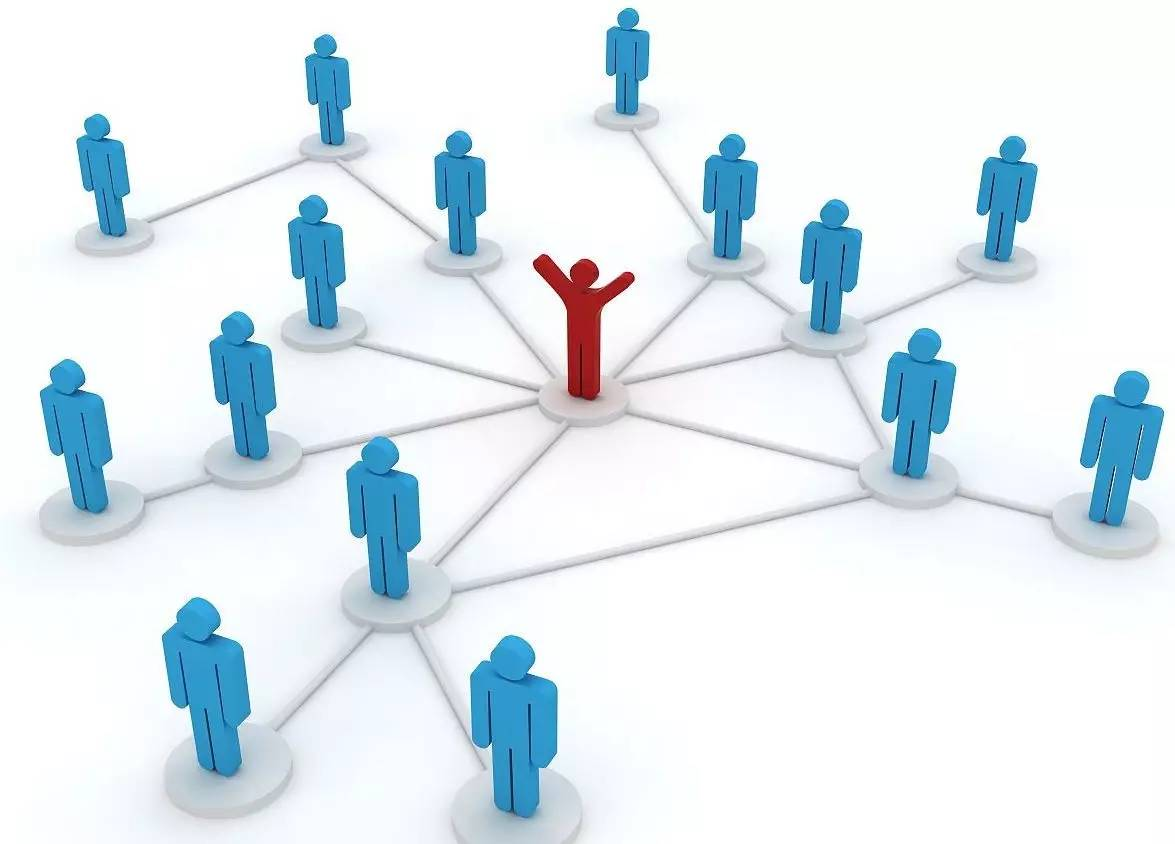

<div id="equation-anchor-4"></div>
$Irreduciable$并且对称的用户联系矩阵（或邻接矩阵）
$\\[10px]$
$$
\begin{equation}\begin{pmatrix}
u_{11} & \cdots & u_{1n} \\
\vdots & \ddots & \vdots \\
u_{n1} & \cdots & u_{nn}
\end{pmatrix}\end{equation}
$$

用户$u_{a}$到$u_{b}$的概率可以表达为
$\\[10px]$
$$\begin{equation}
p(b|a) = \frac{u_{ab}}{\sum\limits_{i=1}^{n}u_{ai}}
\end{equation}$$

因此，用户$u_a$的转移矩阵为
$\\[10px]$
$$\begin{equation}
p = [p(u_1|u_a),p(u_2|u_a),\ldots]
\end{equation}$$

### 拉普拉斯矩阵$L$和其伪逆矩阵（也称摩尔-彭若思广义逆）$L+$

以用户联系矩阵[(4)](#equation-anchor-4)为例，其拉普拉斯矩阵定义为
$$\begin{equation}
L(G) = D(G) - A(G)
\\[10px]
\begin{pmatrix}
degree(u_1) & -u_{12} & \cdots & -u_{1n} \\
-u_{21} & degree(u_2) & \cdots & -u_{2n} \\
\vdots & \ddots & \vdots & \vdots \\
-u_{n1} & -u_{n2} & \cdots & degree(u_n)
\end{pmatrix}\end{equation}$$
$\\[30px]$
根据文献[<sup>[4]</sup>](#refer-anchor-4)，$L+$的定义为
$$\begin{equation}
L+ = (L-ee^T/n)^{-1}+ee^T/n
\end{equation}$$
$\\[10px]$
因为大型稀疏矩阵的逆是极难求解的，根据文献[<sup>[4]</sup>](#refer-anchor-4)提供的迭代方法每次求取$L+$的一行$(l_{i}^+)$以减少运算量

定义单位矩阵$I$、列向量$e_{i}$和$e$

$$I=\begin{pmatrix}
1 & 0 & \cdots & 0 \\
0 & 1 & \cdots & 0 \\
\vdots & \ddots & \vdots & \vdots \\
0 & 0 & \cdots & 1
\end{pmatrix}$$

$$e_{i} = I的第i列向量$$

$$e = 
\begin{bmatrix}
1 & 1 & \cdots & 1
\end{bmatrix}^T
$$

$1.$计算向量$e_{i}在L$的列空间上的投影

$$\begin{equation}
y_{i}=proj_{L}(e_{i})=(I-ee^{T}/n)e_{i}
\end{equation} $$

$2.$找到方程$Ll=y_{i}$的解$l_{i}^{*+}$

$3.$将结果$l_{i}^{*+}$投影到$L$的行空间上

$$\begin{equation}
l_{i}^{+}=proj_{L}(l_{i}^{*+})=(I-ee^{T}/n)l_{i}^{*+}
\end{equation} $$

对**第一步**过程进行再化简
$\\[30px]$
$$
(I-ee^T/n)e_{i} =
\begin{pmatrix}
\frac{n-1}{n} & -\frac{1}{n} & \cdots & -\frac{1}{n} \\
-\frac{1}{n} & \frac{n-1}{n} & \cdots & -\frac{1}{n} \\
\vdots & \ddots & \vdots \\
-\frac{1}{n} & -\frac{1}{n} & \cdots & \frac{n-1}{n}
\end{pmatrix}_{n\times{n}} \cdot e_{i} = 
[\underset{1}{-\frac{1}{n}},\cdots,\underset{i-1}{-\frac{1}{n}},\underset{i}{\frac{n-1}{n}},\underset{i+1}{-\frac{1}{n}},\cdots,\underset{n}{-\frac{1}{n}}]^T = I的第i列每个元素 - \frac{1}{n}
$$
$\\[30px]$

In [ ]:
e_i = I.getcol(0)
e_i = e_i - np.ones((length,1)) / length
y_i = e_i

根据文献[<sup>[4]</sup>](#refer-anchor-4)对**第二步**过程再化简  

使用普通的求解稠密矩阵方程的方法求解大规模的稀疏矩阵方程效率很低  

结合拉普拉斯矩阵**半正定性**，我们使用$cvxopt$库提供的$cvxopt.cholmod.linsolve$方法对$L$进行科列斯基分解并求解方程

In [ ]:
# Cholesky factorization & Solve equation
coo= L.tocoo()
SP = spmatrix(coo.data, coo.row.tolist(), coo.col.tolist())         # ！耗时较长！
b = matrix(y_i, tc='d')
cholmod.linsolve(SP,b)                                              # ！耗时较长！

对**第三步**过程进行再化简
$$
(I-ee^T/n)l_{i}^{*+} =
\begin{pmatrix}
\frac{n-1}{n} & -\frac{1}{n} & \cdots & -\frac{1}{n} \\
-\frac{1}{n} & \frac{n-1}{n} & \cdots & -\frac{1}{n} \\
\vdots & \ddots & \vdots \\
-\frac{1}{n} & -\frac{1}{n} & \cdots & \frac{n-1}{n}
\end{pmatrix}_{n\times{n}} \cdot l_{i}^{*+} =
l_{i1}^{*+}
\begin{pmatrix}
\frac{n-1}{n} \\ -\frac{1}{n} \\ \vdots \\ -\frac{1}{n} \\
\end{pmatrix} +
l_{i2}^{*+}
\begin{pmatrix}
-\frac{1}{n} \\ \frac{n-1}{n} \\ \vdots \\ -\frac{1}{n} \\
\end{pmatrix} + \cdots +
l_{in}^{*+}
\begin{pmatrix}
-\frac{1}{n} \\ \vdots \\ - \frac{1}{n} \\ \frac{n-1}{n} 
\end{pmatrix}
$$
$\\[30px]$
$$
= \begin{pmatrix}
l_{i1}^{*+} \cdot \frac{n-1}{n} - (\sum\limits_{j=1}^{n} l_{ij}^{*+} - l_{i1}^{*+}) \cdot \frac{1}{n} \\
l_{i2}^{*+} \cdot \frac{n-1}{n} - (\sum\limits_{j=1}^{n} l_{ij}^{*+} - l_{i2}^{*+}) \cdot \frac{1}{n} \\
\vdots \\
l_{in}^{*+} \cdot \frac{n-1}{n} - (\sum\limits_{j=1}^{n} l_{ij}^{*+} - l_{in}^{*+}) \cdot \frac{1}{n}
\end{pmatrix} = 
\begin{pmatrix}
l_{i1}^{*+} - \frac{1}{n}\sum\limits_{j=1}^{n} l_{ij}^{*+} \\
l_{i2}^{*+} - \frac{1}{n}\sum\limits_{j=1}^{n} l_{ij}^{*+} \\
\vdots \\
l_{in}^{*+} - \frac{1}{n}\sum\limits_{j=1}^{n} l_{ij}^{*+} \\
\end{pmatrix} = 
\begin{pmatrix}
l_{i1}^{*+} - avg(l_{i}^{*+}) \\
l_{i2}^{*+} - avg(l_{i}^{*+}) \\
\vdots \\
l_{in}^{*+} - avg(l_{i}^{*+}) \\
\end{pmatrix}
$$

In [ ]:
l = np.array(b) - np.mean(np.array(b))

计算出来的$L+$具有什么样的意义？
$\\[0px]$
<center><b>$L+$ provides a <font color="#FF0000">similarity measure $(sim(i,j)=l^{+}_{ij})$</font> since it is the matrix containing</b></center> 
<center><b>the inner products of the node vectors in the Euclidean space where the nodes are exactly separated by the ECTD.</b></center>
<center>(ECTD means Euclidean Commute Time Distance)</center>

$\\[0px]$
$L+$可以用来计算<b><font color="#FF0000">平均通勤时间（Average Commute Time）</font></b>
$\\[0px]$
<center>$ACT(i,j)$<font color="##33CC00">$\downarrow$</font>$= V_G(l_{ii}^{+}+l_{jj}^{+}-2l_{ij}^{+}$<font color="#FF0000">$\uparrow$</font>$)$</center>

$$其中,V_G为所有节点的度的总和$$

$\\[0px]$
以用户$u_{a}$为例，从$u_{a}$转移到每个与其相邻的点的概率即可定义为<b><font color="#FF0000">用户转移矩阵</font></b>
$\\[0px]$
$$p = [p(u_1|u_a),p(u_2|u_a),\ldots]$$

与文献[<sup>[3]</sup>](#refer-anchor-3)[<sup>[4]</sup>](#refer-anchor-4)类似，我们将用户和地点连接成图（即将**用户—用户**和**用户—地点**两个邻接矩阵加入同一张图）  

并用以下的方式生成两个相邻节点间边的权重
$\\[0px]$

| 用户—用户边的权重 |          用户—地点边的权重         | 
| :----: | :----: |
| 是朋友，则 $=1$  | $checkins>$均值 $\&$ $avg(ratings)>$均值 $=1$|
| 不是朋友，则 $=0$ | 反之 $=0$                        |

## 数据来源

### Raw Data

In [2]:
DATA_PATH = "./Raw Data/"
USERS_DATA_PATH = DATA_PATH + "users.csv"
VENUES_DATA_PATH = DATA_PATH + "venues.csv"
SOCIAL_DATA_PATH = DATA_PATH + "socialgraph.csv"
RATINGS_DATA_PATH = DATA_PATH + "ratings.csv"
CHECKINS_DATA_PATH = DATA_PATH + "checkins.csv"

### Clean Data

In [2]:
CLEAN_DATA = "./Clean Data/"
CLEAN_USERS_DATA = CLEAN_DATA + 'users.csv'
CLEAN_RATINGS_DATA = CLEAN_DATA + 'ratings.csv'
CLEAN_SOCIALGRAPH_DATA = CLEAN_DATA + 'socialgraph.csv'
CLEAN_CHECKINS_DATA = CLEAN_DATA + 'checkins.csv'
CLEAN_AGGR_ALL_DATA = CLEAN_DATA + 'aggr.csv'

## 数据结构

In [3]:
all_dtypes = {'checkins': {'id': 'int32', 'user_id': 'int32', 'venue_id': 'int32'},
 'socialgraph': {'first_user_id': 'int32', 'second_user_id': 'int32'},
 'ratings': {'user_id': 'int32', 'venue_id': 'int32', 'rating': 'int8'},
 'users': {'id': 'int32', 'latitude': 'float16', 'longitude': 'float16'},
 'venues': {'id': 'int32', 'latitude': 'float16', 'longitude': 'float16'},
 'aggr': {'rating_mean': 'float16', 'rating_count': 'int16', 'checkins_count': 'float16', 
          'checkins_count_adjust': 'float16'}}

# 数据预处理

## 5个数据集的单独处理

### checkins数据集预处理

#### 读取数据

In [5]:
# 设置chunksize参数，来控制每次迭代数据的大小
checkins_data = pd.DataFrame()
chunker = pd.read_csv(CHECKINS_DATA_PATH,chunksize=500000)
for item in chunker:
    checkins_data = checkins_data.append(item)

In [6]:
checkins_data

,id,user_id,venue_id,latitude,longitude,created_at
0,16,539270,1206,41.878114,-87.629798,2011-12-08 05:08:42
1,17,1330941,1206,0.000000,0.000000,2011-12-08 04:32:19
2,18,1330942,1206,0.000000,0.000000,2011-12-08 04:29:38
3,19,282798,1206,41.878114,-87.629798,2011-12-08 04:26:06
4,20,376793,1206,41.878114,-87.629798,2011-12-08 04:17:50
...,...,...,...,...,...,...
1021961,1021977,244608,11138,0.000000,0.000000,2012-04-23 01:47:05
1021962,1021978,2153502,783,0.000000,0.000000,2012-04-23 01:42:42
1021963,1021979,592192,82919,40.239812,-76.919974,2012-04-22 23:26:48
1021964,1021980,494946,68691,32.912624,-96.638883,2012-04-23 00:36:33


#### 去除该表格中venues的经纬度数据并将create_at字段转化为日期格式
* 我们发现在该数据集中相同venue_id对应的latitude和longitude有细微的差别，考虑可能是用户打卡的地点问题，所以**统一使用venue表中的地理位置信息作为每个地点的经纬度**  
* 将**user_id、venue_id和created_at三个字段均相同**的记录**视为重复并删除**

In [7]:
def clean_checkins_data(cdf):
    # 去除经纬度数据
    cdf = cdf.drop(['latitude','longitude'], axis=1)
    # 将object转为日期格式
    cdf['created_at'] = pd.to_datetime(cdf['created_at'])
    # 去重
    print('存在{}个重复值'.format(cdf.duplicated(['user_id','venue_id','created_at']).sum()))
    cdf = cdf.drop_duplicates(['user_id','venue_id','created_at'])
    # 查看空值
    print('数据集中含有{}个空值'.format(cdf.isna().sum().sum()))
    
    return cdf

In [8]:
cdf = clean_checkins_data(checkins_data)

存在5462个重复值
数据集中含有0个空值


### 社交网络数据预处理

#### 读取数据

In [9]:
#设置chunksize参数，来控制每次迭代数据的大小
social_data = pd.DataFrame()
chunker = pd.read_csv(SOCIAL_DATA_PATH, chunksize=5000000)
for item in chunker:
    social_data = social_data.append(item)

In [10]:
social_data

,first_user_id,second_user_id
0,1,10
1,10,1
2,1,11
3,11,1
4,1,12
...,...,...
27098485,venues,0
27098486,ratings,0
27098487,schema_migrations,0
27098488,(12 rows),0


#### 去除表格尾部字段并转换类型为int
* 表格尾部有一些杂乱的字段，删除  
* 因为id都是整数，直接将float转换为int
* 将**first_user_id和second_user_id两个字段均相同**的记录**视为重复并删除**

In [11]:
def clean_social_data(sdf):
    # 去除尾部字段
    sdf = sdf[:-18]
    # 重新设置索引
    sdf.reset_index(drop=True, inplace=True)
    # 将类型转换成整数int
    sdf = sdf.astype('int64')
    # 去重
    print('存在{}个重复值'.format(sdf.duplicated().sum()))
    sdf = sdf.drop_duplicates()
    # 查看空值
    print('数据集中含有{}个空值'.format(sdf.isna().sum().sum()))
    
    return sdf

In [12]:
sdf = clean_social_data(social_data)

存在9260220个重复值
数据集中含有0个空值


### 用户评分数据预处理

#### 读取数据

In [13]:
#设置chunksize参数，来控制每次迭代数据的大小
ratings_data = pd.DataFrame()
chunker = pd.read_csv(RATINGS_DATA_PATH,chunksize=1000000)
for item in chunker:
    ratings_data = ratings_data.append(item)

In [14]:
ratings_data

,user_id,venue_id,rating
0,1,1,5
1,1,51,4
2,1,51,2
3,1,51,5
4,1,52,5
...,...,...,...
2809575,2153498,91385,2
2809576,2153499,783,2
2809577,2153500,91385,2
2809578,2153501,68691,2


#### 查看空值

In [15]:
def clean_rating_data(rdf):
    # 查看空值
    print('数据集中含有{}个空值'.format(rdf.isna().sum().sum()))
    return rdf

In [16]:
rdf = clean_rating_data(ratings_data)

数据集中含有0个空值


### 用户数据预处理

#### 读取数据

In [80]:
#设置chunksize参数，来控制每次迭代数据的大小
users_data = pd.DataFrame()
chunker = pd.read_csv(USERS_DATA_PATH,chunksize=1000000)
for item in chunker:
    users_data = users_data.append(item)

In [81]:
users_data

,id,latitude,longitude
0,1,45.072464,-93.455788
1,2,30.669682,-81.462592
2,3,43.549975,-96.700327
3,4,44.840798,-93.298280
4,5,27.949436,-82.465144
...,...,...,...
2153464,2153498,0.000000,0.000000
2153465,2153499,0.000000,0.000000
2153466,2153500,0.000000,0.000000
2153467,2153501,0.000000,0.000000


#### 去重和查看空值
* 将**id、latitude和longitude三个字段均相同**的记录**视为重复并删除**  
* 经纬度均为0的家乡认为是缺失值，填充Null

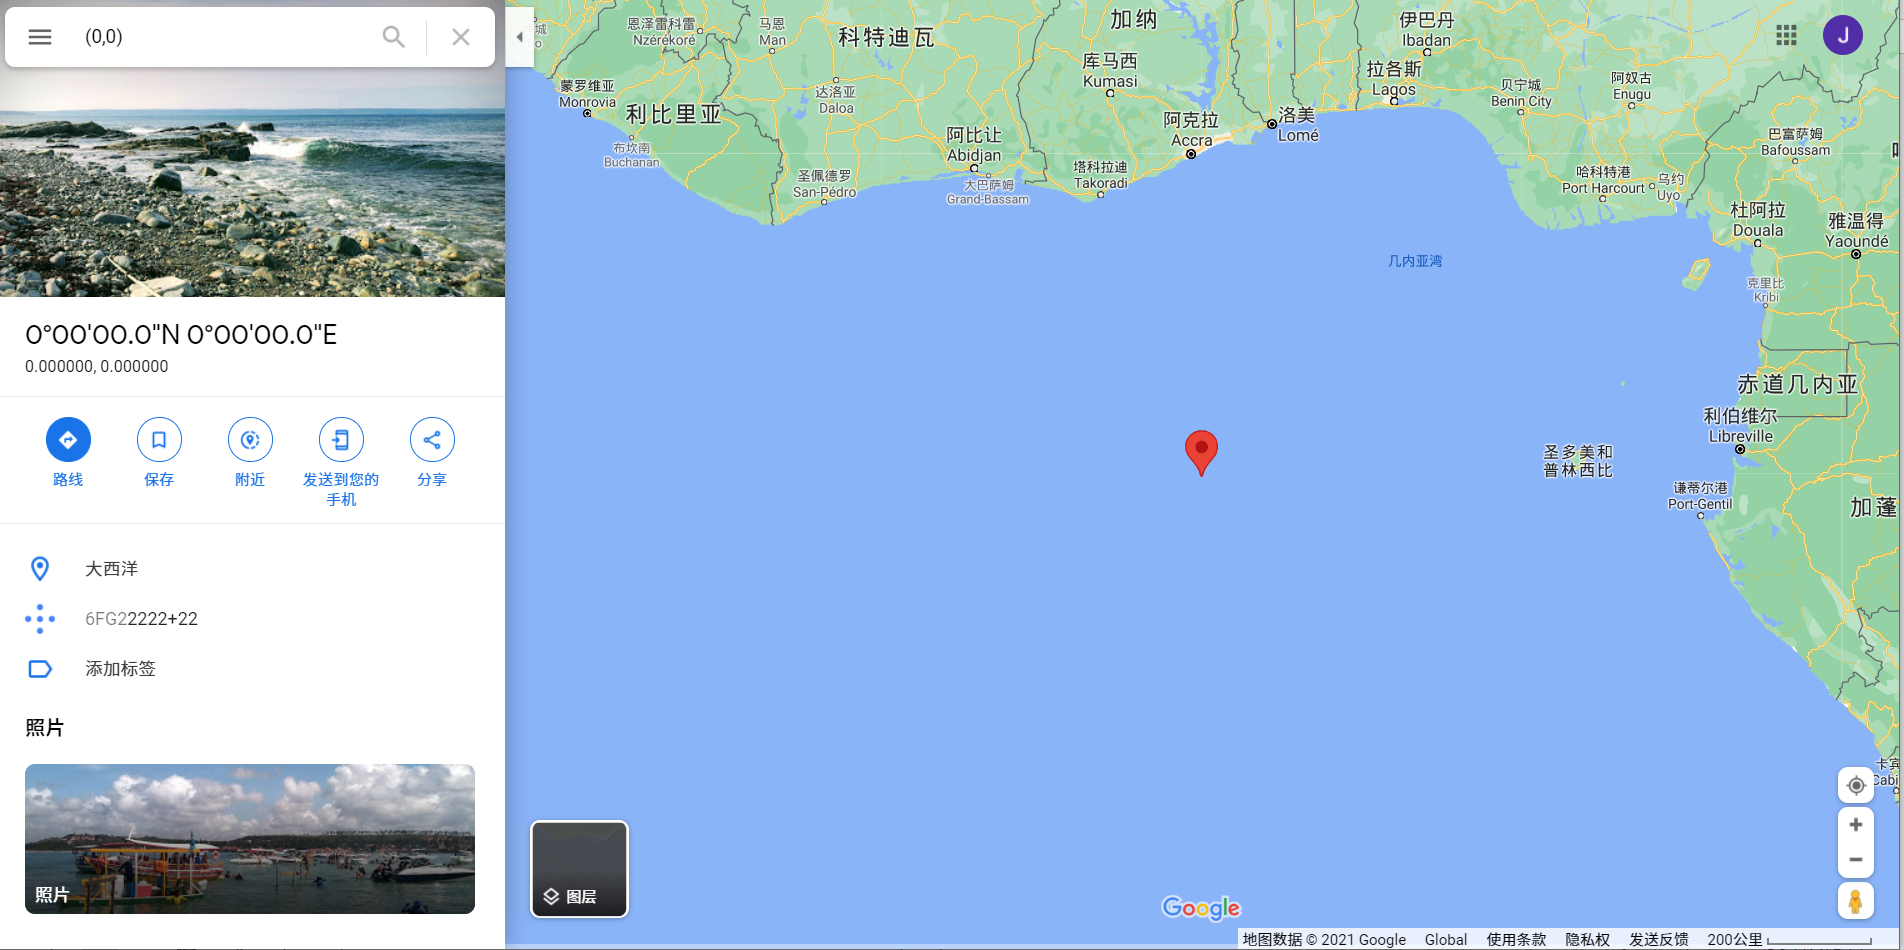

In [82]:
def clean_users_data(udf):
    # 去重
    print('存在{}个重复值'.format(udf.duplicated().sum()))
    udf = udf.drop_duplicates()
    # 查看空值
    print('数据集中含有{}个空值'.format(udf.isna().sum().sum()))
    # 置空值为Null
    null_idx = list(udf[(udf['latitude']==0)&(udf['longitude']==0)].index)
    udf.loc[null_idx, 'latitude':'longitude'] = np.nan
    print('共{}个地点缺失，置为Null！'.format(udf.isna().sum().sum()/2))
    
    return udf

In [83]:
udf = clean_users_data(users_data)

存在0个重复值
数据集中含有0个空值


#### 纬度数据大于90°或小于-90°，或经度数据大于180°或小于-180°，则认为地理信息记录出错，填充Null值

In [99]:
def set_error_lat_and_lon(df):
    has_null = df.isna().sum().sum()/2
    lat_error_idx = list(df[(df['latitude']>90)|(df['latitude']<-90)].index)
    lon_error_idx = list(df[(df['longitude']>180)|(df['longitude']<-180)].index)
    df.loc[lat_error_idx+lon_error_idx, 'latitude':'longitude'] = np.nan
    print('共{}个地点的经纬度数据记录错误，置为Null！'.format(df.isna().sum().sum()/2 - has_null))
    
    return df

In [100]:
udf = set_error_lat_and_lon(udf)

共0.0个地点的经纬度数据记录错误，置为Null！


### 地点数据预处理

#### 读取数据

In [101]:
venues_data = pd.DataFrame()
chunker = pd.read_csv(VENUES_DATA_PATH,chunksize=500000)
for item in chunker:
    venues_data = venues_data.append(item)

In [102]:
venues_data

,id,latitude,longitude
0,1,44.882011,-93.212364
1,2,44.883169,-93.213687
2,3,44.883455,-93.214316
3,4,44.881387,-93.213801
4,5,44.882129,-93.214012
...,...,...,...
1143085,1143087,0.000000,0.000000
1143086,1143088,0.000000,0.000000
1143087,1143089,0.000000,0.000000
1143088,1143090,0.000000,0.000000


#### 判断空值

In [103]:
print('数据集中含有{}个空值'.format(venues_data.isna().sum().sum()))

数据集中含有0个空值


#### 地点数据去重
* **将lontitude和latitude均为0**的数据置为Null（因为该数据为缺失数据）

In [104]:
# 对地点数据做应进行修改
def revise_venues_df(vdf):
    # 判断缺失数据
    null_idx = list(vdf[(vdf['latitude']==0)&(vdf['longitude']==0)].index)
    # 将缺失值置为Null
    vdf.loc[null_idx, 'latitude':'longitude'] = np.nan
    print('共{}个地点缺失，置为Null！'.format(vdf.isna().sum().sum()/2))
    return vdf

In [105]:
vdf = revise_venues_df(venues_data)

共1327.0个地点缺失，置为Null！


#### 纬度数据大于90°或小于-90°，或经度数据大于180°或小于-180°，则认为地理信息记录出错，对其置为Null

In [106]:
vdf = set_error_lat_and_lon(vdf)

共1.0个地点的经纬度数据记录错误，置为Null！


## 数据集整合的预处理

### 查看各数据集之间的数据是否均匹配

In [112]:
# 判断cdf的uid是否都在udf表中
set(cdf['user_id']) - set(udf['id'])
# 判断cdf的vid是否都在vdf表中
set(cdf['venue_id']) - set(vdf['id'])
# 判断social表中的uid是否都在udf表中
set(sdf['first_user_id']) - set(udf['id'])
set(sdf['second_user_id']) - set(udf['id'])
# 判断ratings中的uid是否都在udf表中
set(rdf['user_id']) - set(udf['id'])
# 判断ratings中的vid是否都在vdf表中
set(rdf['venue_id']) - set(vdf['id'])

set()

set()

set()

set()

set()

set()

### 分析每个节点的入度和出度是否相等以检查是否存在**“关注”**行为
* 可以观察到：（一）仅有2个节点入度大于出度，差值为1；（二）1个节点的出度大于入度，差值为2。
* 因此，可以**忽略“关注”行为**

In [27]:
def search_no_bothway(G):
    # 记录入度-出度的差值
    point_degree_difference = {}  
    for node in G.nodes():
        # 入度-出度
        point_degree_difference[node] = G.in_degree(node) - G.out_degree(node)
            
    return point_degree_difference

In [28]:
# 创建空的简单有向图
G=nx.DiGraph()  
# 添加边
G.add_edges_from(sdf.values)   
# 分析入度-出度
point_degree_difference = search_no_bothway(G)

In [29]:
pd.DataFrame(sorted(point_degree_difference.items(), key=lambda x : x[1], reverse=True), columns=['node','difference'])

,node,difference
0,1562442,1
1,1562480,1
2,1,0
3,10,0
4,11,0
...,...,...
1880401,2090033,0
1880402,1764449,0
1880403,2146571,0
1880404,2146575,0


### 处理评分数据和checkins不匹配的问题
* 如果有rating的数量和checkins的数量**不匹配**，以**最多的那个为访问频率**作为checkins的次数
* 如果**有checkins没有rating**，**将rating设置为1**（不存在该情况）

#### 观察rating数据

In [30]:
rdf.rating.describe()

count    2.809580e+06
mean     3.515076e+00
std      1.275262e+00
min      2.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

#### 使用**dask**进行加速运算

In [113]:
rdfdd = dd.read_csv(RATINGS_DATA_PATH)
cdfdd = dd.read_csv(CHECKINS_DATA_PATH, parse_dates=['created_at'])

In [114]:
# 聚合用户对某一个地点的评分和频率
def aggregation_of_rates(rating):
    # 用户对某地点评分的均值
    df_mean = rating.groupby(['user_id','venue_id']).rating.mean()
    df_mean = pd.DataFrame(df_mean.compute())
    df_mean.columns = ['rating_mean']
    # 用户对某地点评分的次数
    df_count = rating.groupby(['user_id','venue_id']).rating.count()
    df_count = pd.DataFrame(df_count.compute())
    df_count.columns = ['rating_count']
    df = pd.merge(df_mean, df_count, how='inner', left_index=True, right_index=True)
    return df

# 聚合用户对某一个地点的访问频率
def aggregation_of_checks(checkins):
    # 用户对某地点的checkins次数
    df = checkins.groupby(['user_id','venue_id']).id.count()
    df = pd.DataFrame(df.compute())
    df.columns = ['checkins_count']
    return df

In [115]:
aggr_rating_df = aggregation_of_rates(rdfdd)
aggr_check_df = aggregation_of_checks(cdfdd)
aggr_all = pd.merge(aggr_rating_df, aggr_check_df, how='outer', left_index=True, right_index=True)
# 使用rating_count填充checkins_count的缺失值
aggr_all.checkins_count.fillna(aggr_all.rating_count, inplace=True)
# # 调整后的checkins_count
aggr_all['checkins_count_adjust'] = np.maximum(aggr_all.rating_count.values, aggr_all.checkins_count.values)

In [116]:
aggr_all

rating_mean  rating_count  checkins_count  \
user_id venue_id                                              
1       1            5.000000             1             1.0   
        51           3.666667             3             1.0   
        52           5.000000             1             1.0   
        53           5.000000             1             1.0   
        54           5.000000             1             1.0   
...                       ...           ...             ...   
2153498 91385        2.000000             1             1.0   
2153499 783          2.000000             1             1.0   
2153500 91385        2.000000             1             1.0   
2153501 68691        2.000000             1             1.0   
2153502 783          2.000000             1             1.0   

                  checkins_count_adjust  
user_id venue_id                         
1       1                           1.0  
        51                          3.0  
        52                          1.0  
        53                          1.0  
        54                          1.0  
...                                 ...  
2153498 91385                       1.0  
2153499 783                         1.0  
2153500 91385                       1.0  
2153501 68691                       1.0  
2153502 783                         1.0  

[2436723 rows x 4 columns]

## 数据结构优化
* 减少内存，加速计算

### 记录dtype

In [117]:
# 记录每个文件读取时的dtype
all_dtypes = {}

### 减少内存占用

In [118]:
# reduce_mem_usage 函数通过调整数据类型，帮助我们减少数据在内存中占用的空间
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            elif str(col_type)[:8] == 'datetime':
                pass
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

# 清洗并保存数据
def clean_and_save_data(df, dict_dt, name):
    df = reduce_mem_usage(df)
    dict_dt[name] = dict(df.dtypes.map(lambda x: str(x)))
    if name != 'aggr':
        df.to_csv('./Clean Data/{}.csv'.format(name), index=0)
    else:
        df.to_csv('./Clean Data/{}.csv'.format(name))
    print('{}数据保存成功！'.format(name))

In [119]:
df_all = [cdf, sdf, rdf, udf, vdf, aggr_all]
name_all = ['checkins', 'socialgraph', 'ratings', 'users', 'venues', 'aggr']
for df,n in zip(df_all, name_all):
    clean_and_save_data(df, all_dtypes, n)

Memory usage of dataframe is 28458696.00 MB
Memory usage after optimization is: 28458696.00 MB
Decreased by 0.0%
checkins数据保存成功！
Memory usage of dataframe is 142706144.00 MB
Memory usage after optimization is: 142706144.00 MB
Decreased by 0.0%
socialgraph数据保存成功！
Memory usage of dataframe is 25286348.00 MB
Memory usage after optimization is: 25286348.00 MB
Decreased by 0.0%
ratings数据保存成功！
Memory usage of dataframe is 152797088.00 MB
Memory usage after optimization is: 118341584.00 MB
Decreased by 22.5%
users数据保存成功！
Memory usage of dataframe is 27434288.00 MB
Memory usage after optimization is: 9144848.00 MB
Decreased by 66.7%
venues数据保存成功！
Memory usage of dataframe is 174803433.00 MB
Memory usage after optimization is: 116322081.00 MB
Decreased by 33.5%
aggr数据保存成功！


# 马尔科夫链预处理

## 读入数据

In [4]:
udf = pd.read_csv(CLEAN_USERS_DATA, dtype=all_dtypes['users'])
sdf = pd.read_csv(CLEAN_SOCIALGRAPH_DATA, dtype=all_dtypes['socialgraph'])
aggr_all = pd.read_csv(CLEAN_AGGR_ALL_DATA, index_col=[0,1], dtype=all_dtypes['aggr'])

## 构造转换字典
* **tdict['uid']:** {uid : node_id}
* **tdict['vid']:** {vid : node_id}
* **rtdict['uid']:** {node_id : uid}
* **rtdict['vid']:** {node_id : vid}

In [15]:
def transfer_dict(uid,vid):
    # 字典总长度
    new_id = list(range(len(uid+vid)))
    # 正向字典：{真实id：node_id}
    transfer_dict = {'uid':dict(zip(uid, new_id[:len(uid)])), 'vid':dict(zip(vid, new_id[len(uid):]))}
    # 逆向字典：{node_id：真实id}
    reverse_transfer_dict = {'uid':dict(zip(new_id[:len(uid)], uid)), 'vid':dict(zip(new_id[len(uid):], vid))}
    return transfer_dict, reverse_transfer_dict

In [16]:
tdict, rtdict = transfer_dict(list(udf.id.values), np.unique(aggr_all.reset_index(drop=False).venue_id.values).tolist())

In [17]:
# 观察node为多少的时候开始是地点
tdict['vid'][1]

2153469

## 使用**scipy.sparse.lil_matrix**初始化邻接矩阵
* 使用该稀疏矩阵类型的原因是**方便后续的修改（加入）**

In [18]:
# 稀疏矩阵长度
len_of_id = len(list(udf.id.values)+np.unique(aggr_all.reset_index(drop=False).venue_id.values).tolist())
# 创建稀疏矩阵
adjacency = sparse.lil_matrix((len_of_id, len_of_id),dtype='int8')

## 构造邻接矩阵（无权拉普拉斯矩阵）

In [19]:
sdf

,first_user_id,second_user_id
0,1,10
1,10,1
2,1,11
3,11,1
4,1,12
...,...,...
17838247,456244,97074
17838248,97074,186390
17838249,186390,97074
17838250,97074,143776


### 用户之间的邻接矩阵
* 好友之间的距离设置为 $1$
* 非好友之间的距离设置为 $0$  

In [20]:
# 创建用户-用户邻接矩阵
def create_user_user_adj(tdict, social, adj):
    udict = tdict['uid']
    # 通过字典进行转换
    row = list(social.first_user_id.map(lambda x: udict[x]).values)
    line = list(social.second_user_id.map(lambda x: udict[x]).values)
    # 因为原数据已经是双向了，所以只需要连接一次
    adj[row,line] = 1
    return adj

In [21]:
adjacency = create_user_user_adj(tdict, sdf, adjacency)

### 用户-地点的邻接矩阵  
* 直接使用均值对数据进行划分
* 评分均分 $>=$ 均值 或访问次数 $>=$ 均值，则连接为1；反之则为0
* 使用**swifter**进行加速

In [22]:
aggr_all

rating_mean  rating_count  checkins_count  \
user_id venue_id                                              
1       1            5.000000             1             1.0   
        51           3.666016             3             1.0   
        52           5.000000             1             1.0   
        53           5.000000             1             1.0   
        54           5.000000             1             1.0   
...                       ...           ...             ...   
103224  833901       5.000000             1             1.0   
        833530       5.000000             1             1.0   
        833861       5.000000             1             1.0   
        833919       5.000000             1             1.0   
        833395       5.000000             1             1.0   

                  checkins_count_adjust  
user_id venue_id                         
1       1                           1.0  
        51                          3.0  
        52                          1.0  
        53                          1.0  
        54                          1.0  
...                                 ...  
103224  833901                      1.0  
        833530                      1.0  
        833861                      1.0  
        833919                      1.0  
        833395                      1.0  

[2434975 rows x 4 columns]

In [13]:
aggr_all = aggr_all.astype('float32')
aggr_all.describe()
aggr_all = aggr_all.astype(all_dtypes['aggr'])

,rating_mean,rating_count,checkins_count,checkins_count_adjust
count,2.436723e+06,2.436723e+06,2.436723e+06,2.436723e+06
mean,3.559600e+00,1.153016e+00,1.151342e+00,1.155248e+00
std,1.290131e+00,5.540870e-01,5.515010e-01,5.594989e-01
min,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
50%,4.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
75%,5.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
max,5.000000e+00,1.370000e+02,1.370000e+02,1.370000e+02


In [14]:
# 将数据按0、1分隔开
aggr_count = aggr_all.swifter.apply(lambda x: (x['rating_mean']>=3.6)|(x['checkins_count_adjust']>=2), axis=1)

In [15]:
# 创建用户-地点邻接矩阵
def create_user_venue_adj(tdict, aggr, adj):
    udict = tdict['uid']
    vdict = tdict['vid']
    # 通过字典进行转换
    row = [udict[i[0]] for i in list(aggr[aggr].index)]
    line = [vdict[i[1]] for i in list(aggr[aggr].index)]
    # 需要双向连接
    adj[row,line] = 1
    adj[line,row] = 1
    return adj

In [16]:
adjacency = create_user_venue_adj(tdict, aggr_count, adjacency)

In [17]:
# g观察邻接矩阵的大小
adjacency.get_shape()

(3293963, 3293963)

In [18]:
# 保存邻接矩阵
sparse.save_npz('adj_matrix.npz', adjacency.tocsc())

## 根据邻接矩阵生成图

In [19]:
# 读取邻接矩阵
adjacency = sparse.load_npz('adj_matrix.npz')
# 根据邻接矩阵生成图
G = nx.from_scipy_sparse_matrix(adjacency)

# 马尔科夫链

## 寻找checkins数量前10的用户

In [20]:
# 找出拥有最多checkins的前10名用户
most_checkins_users = list(aggr_all.groupby(['user_id']).checkins_count_adjust.sum()\
                          .sort_values(ascending=False).index)[:10]

In [21]:
most_checkins_users

[30200, 54953, 103224, 281, 4442, 79082, 41460, 56474, 61219, 46040]

## 获取目标节点两步之内的所有节点构成图网络并计算拉普拉斯矩阵$L$
* 计算整张图的开销很大（$320万\times320万$的稀疏邻接矩阵），并且意义也不是很大。
* 因此取以**每个中心节点（每个most_checkins_user）两步内能到达的所有节点构成的子图**作为分析对象

In [22]:
# 将uid列表转为node_id列表
def transfer_uid_list_2_node(l, tdict):
    nlist = []
    for n in l:
        nlist.append(tdict['uid'][n])
        
    return nlist

# 获取目标节点limit步以内的所有节点构成图网络（这里limit为2，
# 同时我们去除了第二步的user的user节点，保留由地点引出的user节点。因为二层user作用比较少，又会增大计算量）
def get_sub_graphs(G, nlist, tdict, limit=2, drop_none_friends=True):
    # 先将uid列表（nlist）转换为node_id列表
    nlist = transfer_uid_list_2_node(nlist, tdict)
    sub_graphs = []
    for n in tqdm(nlist):
        # 获取limit步以内的图构成图网络
        nodes = list(nx.dfs_preorder_nodes(G, n, limit))
        sub = nx.subgraph(G, nodes)
        # 删除第二步的user的user节点
        if drop_none_friends:
            loc_id = tdict['vid'][1]
            friends_nodes = [user for user in list(sub.adj[n]) if user < loc_id]
            loc_nodes = [loc for loc in list(sub.nodes) if loc >= loc_id]
            nodes = friends_nodes + loc_nodes
            # 记录由地点引出的user节点
            loc_user = []
            loc_nodes = [loc for loc in sub.adj[n] if loc >= loc_id]
            for loc in loc_nodes:
                loc_user.append(list(sub.adj[loc]))
            loc_user = sum(loc_user, [])
            nodes = list(set(nodes + loc_user))  
            nodes.remove(n)
            nodes = [n] + nodes
        
        sub = nx.subgraph(G, nodes)
        sub_graphs.append([nodes, sub])

    return sub_graphs


# 直接获取拉普拉斯矩阵
def get_L(sub_graphs_l, weight='weight'):
    Ls = []
    for sub in tqdm(sub_graphs_l):
        node_list = sub[0]
        graph = sub[1]
        Ls.append(nx.linalg.laplacianmatrix.laplacian_matrix(graph, node_list, weight))
        
    return Ls

In [23]:
# 获取不带第二层user的子图
sub_graphs_list = get_sub_graphs(G, most_checkins_users, tdict)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.22it/s]


In [24]:
# 保存node_list
nodes_list = [s[0] for s in sub_graphs_list]
np.savez('./graph/node_list.npz', result=np.array(nodes_list, dtype=object))

In [25]:
# 获取子图的拉普拉斯矩阵
Ls = get_L(sub_graphs_list)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.25it/s]


## 改进的图网络生成的拉普拉斯矩阵$L$ 
* 计算用户与其好友的$Jaccard$相似度（包括地点和好友的$Jaccard$相似度）
* 用户与地点之间的邻近程度由以下公式得到
$$用户对该地点的评分均值 \times \sqrt[3]{用户访问的次数}$$

In [157]:
# 计算Jaccard相似系数并返回weight属性更新的graph
def jaccard_sparse(graph, node_l, tdict, keep_nodes):
    target = node_l[0]
    loc_id = tdict['vid'][1]
    user_id = [user for user in keep_nodes if user < loc_id]
    similarity = []
    for u in tqdm(user_id):
        adj = set(graph.adj[u])
        for au in [a for a in adj if ((a < loc_id) and (a in keep_nodes))]:
            au_adj = set(graph.adj[au])
            union = adj | au_adj
            intrsct = adj & au_adj
            jaccard = len(intrsct) / len(union)
            similarity.append((u, au, jaccard))
    
    # jaccard 归一化
    similarity = pd.DataFrame(similarity, columns=['user_1','user_2','similarity'])
    max_ =  similarity['similarity'].max()
    min_ = similarity['similarity'].min() - 0.00001
    similarity['similarity'] = similarity['similarity'].map(lambda x: (x-min_)/(max_-min_))
    similarity = similarity[['user_1', 'user_2', 'similarity']].values
    
    similarity = [(i[0], i[1], {'weight':i[2]}) for i in similarity]
    print('归一化完成')
    
    # 解冻
    graph = nx.Graph(graph)
    
    # 添加第一层的user相似度
    graph.add_edges_from(similarity)
    print('添加第一层user相似度完成')
    
    # 删除多余的user节点
    graph = nx.subgraph(graph, keep_nodes)
    print('删除第二层user完成')
    
    return graph

# 计算用户对地点的偏好程度并返回weight属性更新的graph
def user_preference(aggr, graph, node_l, tdict, rtdict):
    loc_id = tdict['vid'][1]
    user_g = np.array(node_l)[np.array(node_l) < loc_id]
    user = [rtdict['uid'][ug] for ug in user_g]
    # 筛选出那些有checkins的用户
    has_checkins = aggr.reset_index(drop=False, inplace=False)['user_id'].values
    user = list(set(user) & set(has_checkins))
    aggr = aggr.loc[user, :]
    # 筛选出在图中的vid
    loc = [loc for loc in graph.nodes if loc >= loc_id]
    
    # 对评分进行归一化
    max_ = np.max(aggr['rating_mean'])
    min_ = np.min(aggr['rating_mean'])
    aggr['rating_mean'] = aggr['rating_mean'].map(lambda x: (x-min_)/(max_-min_))
    aggr['total_point'] = aggr.apply(lambda x: x['rating_mean']*pow(x['checkins_count_adjust'], 1/3), axis=1)
    aggr.reset_index(drop=False, inplace=True)
    preference = aggr[['user_id', 'venue_id', 'total_point']]
    preference['user_id'] = preference['user_id'].map(lambda x: tdict['uid'][x])
    preference['venue_id'] = preference['venue_id'].map(lambda x: tdict['vid'][x])
    # 筛选出在图中的vid
    preference = preference[preference['venue_id'].isin(loc)]
    # 结果归一化
    max_ = preference['total_point'].max()
    min_ = preference['total_point'].min() - 0.00001
    preference['total_point'] = preference['total_point'].map(lambda x: (x-min_)/(max_-min_))
    preference = preference[['user_id', 'venue_id', 'total_point']].values
    
    preference = [(i[0], i[1], {'weight': i[2]}) for i in preference] + [(i[1], i[0], {'weight': i[2]}) for i in preference]
    print('归一化完成')
    
    # 解冻
    graph = nx.Graph(graph)
    
    # 添加用户对地点的偏好
    graph.add_edges_from(preference)
    print('添加地点用户偏好完成')
    
    return graph

# 根据子图计用户间的相似度
def similarity_of_each_friend(sub_graphs_l, tdict, keep_node_l):
    new_sub_graphs_list = []
    i = 0
    for sub in tqdm(sub_graphs_l):
        node_list = sub[0]
        graph = sub[1]
        keep_nodes = keep_node_l[i]
        new_graph = jaccard_sparse(graph, node_list, tdict, keep_nodes)
        new_sub_graphs_list.append([keep_nodes, new_graph])
        i += 1

    return new_sub_graphs_list

# 地点的评分和访问次数综合打分并修改连接数值
def location_preference(aggr, sub_graphs_l, tdict, rtdcit):
    new_sub_graphs_list = []
    for sub in tqdm(sub_graphs_l):
        aggr = aggr.copy()
        node_list = sub[0]
        graph = sub[1]
        new_graph = user_preference(aggr, graph, node_list, tdict, rtdict)
        new_sub_graphs_list.append([node_list, new_graph])
    
    return new_sub_graphs_list
        
def get_new_sub_graphs_list(aggr, sub_graphs_l, tdict, rtdict, keep_node_l):
    new_sub_graphs_list = similarity_of_each_friend(sub_graphs_l, tdict, keep_node_l)
    new_sub_graphs_list = location_preference(aggr, new_sub_graphs_list, tdict, rtdict)
    
    return new_sub_graphs_list

In [ ]:
# 获取带第二层user的子图
sub_graphs_list_with_users = get_sub_graphs(G, most_checkins_users, tdict, drop_none_friends=False)
# 计算Jaccard相似系数和综合评分并返回
new_sub_graphs_list = get_new_sub_graphs_list(aggr_all, sub_graphs_list_with_users, tdict, rtdict, nodes_list)

In [159]:
def save_new_sub_graphs(new_sub_graphs_l):
    i = 1
    for nsg in tqdm(new_sub_graphs_l):
        nl = nsg[0]
        graph = nsg[1]
        adj = nx.adjacency_matrix(graph, nl)
        sparse.save_npz('./graph/similar/{}.npz'.format(i), adj)
        i += 1

In [160]:
save_new_sub_graphs(new_sub_graphs_list)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.90it/s]


In [161]:
# 保存node_list
nodes_list_new = [s[0] for s in new_sub_graphs_list]
np.savez('./graph/node_list_similar.npz', result=np.array(nodes_list_new, dtype=object))

In [162]:
def read_graph():
    new_sub_graphs_list = []
    nodes_list = np.load('./graph/node_list_similar.npz', allow_pickle=True)['result']
    for i in tqdm(list(range(1,11))):
        sub_graph = nx.from_scipy_sparse_matrix(sparse.load_npz('./graph/similar/{}.npz'.format(i)))
        node_list = nodes_list[i-1]
        new_sub_graphs_list.append([node_list, sub_graph])
    
    return new_sub_graphs_list

In [163]:
# 读取子图
new_sub_graphs_list = read_graph()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.02it/s]


In [164]:
# 直接获取拉普拉斯矩阵
def get_L_new(sub_graphs_l, weight='weight'):
    Ls = []
    for sub in tqdm(sub_graphs_l):
        graph = sub[1]
        node_list = list(range(len(sub[0])))
        Ls.append(nx.linalg.laplacianmatrix.laplacian_matrix(graph, node_list, weight))
        
    return Ls

In [165]:
Ls_new = get_L_new(new_sub_graphs_list)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.44s/it]


## 参考论文中的4.3 Computational Issues部分计算 ${L+}$

In [166]:
def cal_target_L_sum(Ls):
    L_sum = []
    
    # 对每一个L
    for L in tqdm(Ls):
        
        length = L.get_shape()[0]
        I = sparse.identity(length)
        
        # ======================= 第一步 =======================
        # 计算i=0的情况，即只计算目标与其他点之间的相似度
        e_i = I.getcol(0)
        e_i = e_i - np.ones((length,1)) / length
        y_i = e_i
    
        # ======================= 第二步 =======================
        # Cholesky factorization & Solve equation
        coo= L.tocoo()
        SP = spmatrix(coo.data, coo.row.tolist(), coo.col.tolist())         # ！耗时较长！
        b = matrix(y_i, tc='d')
        try:
            cholmod.linsolve(SP,b)                                          # ！耗时较长！
        except ArithmeticError:
            print('方程无法分解，考虑直接求解！')
            umfpack.linsolve(SP,b)

        # ======================= 第三步 =======================
        l = np.array(b) - np.mean(np.array(b))
        L_sum.append(l)
        
        # ====================================================
    
    return L_sum

In [167]:
L_sum = cal_target_L_sum(Ls)

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  9.61it/s]

方程无法分解，考虑直接求解！


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.15it/s]

方程无法分解，考虑直接求解！
方程无法分解，考虑直接求解！
方程无法分解，考虑直接求解！


In [168]:
L_sum_new = cal_target_L_sum(Ls_new)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 16.26it/s]

方程无法分解，考虑直接求解！
方程无法分解，考虑直接求解！


## 保存结果

In [169]:
# 评分归一化和统计量输出
def standard_and_describe(result, other_result=None):
    i = 1
    new_result = []
    describe_df = pd.DataFrame()
    for r in result:
        if isinstance(r, str) and other_result is not None:
            new_result.append(other_result[i-1])
            r = other_result[i-1]
        else:
            r = (r-r.min())/(r.max() - r.min())
            new_result.append(r)

        # 输出r[0]!=1的情况
        if r[0] != 1:
            print('第{}个结果可能存在问题！'.format(i))
            break
        # 记录describe
        r = pd.DataFrame(r).describe()
        r.columns = [i]
        describe_df = pd.concat([describe_df, r], axis=1)
        i += 1
    return describe_df, new_result

In [170]:
describe, result = standard_and_describe(L_sum)

In [171]:
describe

,1,2,3,4,5,6,7,8,9,10
count,2944.000000,4323.000000,1179.000000,9881.000000,13642.000000,1173.000000,2808.000000,1630.000000,1509.000000,1104.000000
mean,0.457911,0.779840,0.595799,0.801971,0.781040,0.444606,0.746023,0.445451,0.390123,0.421949
std,0.408504,0.170479,0.399588,0.150851,0.117664,0.450859,0.168023,0.394487,0.396646,0.436762
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.110799,0.745881,0.165096,0.778376,0.762557,0.004823,0.696741,0.149880,0.070516,0.029695
50%,0.193095,0.810328,0.948628,0.830734,0.801399,0.100324,0.722107,0.212377,0.156822,0.122310
75%,0.971196,0.874424,0.948628,0.883903,0.843571,0.975606,0.765306,0.964419,0.968254,0.969259
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [172]:
np.savez('L_sum.npz', result=np.array(result, dtype=object))

In [173]:
describe_new, result_new = standard_and_describe(L_sum_new, result)

In [174]:
describe_new

,1,2,3,4,5,6,7,8,9,10
count,2944.000000,4323.000000,1179.000000,9881.000000,13642.000000,1173.000000,2808.000000,1630.000000,1509.000000,1104.000000
mean,0.972260,0.985667,0.987868,0.991550,0.995888,0.984001,0.969965,0.984849,0.989768,0.983687
std,0.045182,0.088394,0.082685,0.060579,0.034095,0.108881,0.169351,0.098090,0.044379,0.098866
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.957068,0.999767,0.996705,0.999763,0.999504,0.995950,0.999721,0.997509,0.988572,0.988926
50%,0.957536,0.999827,0.999987,0.999836,0.999726,0.996270,0.999722,0.997525,0.988851,0.990474
75%,0.999965,0.999847,0.999987,0.999853,0.999760,0.999990,0.999834,0.999997,0.999983,0.999971
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [175]:
np.savez('L_sum_new.npz', result=np.array(result_new, dtype=object))

# 记录最终的结果

In [176]:
# 加载node_list
nodes_list = np.load('./graph/node_list.npz', allow_pickle=True)['result']
# 加载node_list_new
nodes_list_new = np.load('./graph/node_list_similar.npz', allow_pickle=True)['result']
# 加载L_sum
L_sum = np.load('./L_sum.npz', allow_pickle=True)['result']
# 加载L_sum_new
L_sum_new = np.load('./L_sum_new.npz', allow_pickle=True)['result']

## 获取用户间的$l_{ij}$并且归一化（无权拉普拉斯矩阵）

In [177]:
def get_u_ij_similar(L_sum, node_l, rtdict):
    similar = {}
    for l_add, nodes in tqdm(list(zip(L_sum, node_l))):
        # 获取中心节点（most_checkins_user）的node_id
        user = nodes[0]
        nodes = pd.DataFrame(nodes)
        # 获取node_id中uid的部分
        nodes = nodes[nodes[0].isin(rtdict['uid'])]
        df = pd.DataFrame(l_add).loc[list(nodes.index), :]
        # 获取其他users
        df = df.iloc[1:,:]
        # 归一化
        df = (df-df.min()) / (df.max()-df.min())
        # 匹配uid
        df['uid'] = nodes.iloc[1:,:].apply(lambda x: rtdict['uid'][x[0]], axis=1)
        similar[int(rtdict['uid'][user])] = dict(zip(df['uid'], df[0]))
        
    return similar

In [178]:
similar_dict = get_u_ij_similar(L_sum, nodes_list, rtdict)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.67it/s]


In [ ]:
similar_dict

In [180]:
similar_json = json.dumps(similar_dict)
filename='similar.json'
with open(filename,'w') as file_obj:
    json.dump(similar_json,file_obj)

## 获取target用户与没去过的地点 的𝑙𝑖𝑗 并且归一化（加权拉普拉斯矩阵）

In [181]:
def get_loc_ij_similar(L_sum_new, node_l_new, aggr, rtdict):
    similar = {}
    for l_add, nodes in tqdm(list(zip(L_sum_new, node_l_new))):
        # 获取中心节点（most_checkins_user）的node_id
        user = int(rtdict['uid'][nodes[0]])
        nodes = pd.DataFrame(nodes)
        # 获取node_id中vid的部分
        nodes = nodes[nodes[0].isin(rtdict['vid'])]
        df = pd.DataFrame(l_add).loc[list(nodes.index), :]
        # 获取用户去过的地点
        has_gone_loc = list(aggr.loc[user,:].index)
        # 匹配vid
        df['vid'] = nodes.apply(lambda x: rtdict['vid'][int(x[0])], axis=1)
        # 删除用户去过的地点
        df = df[~df['vid'].isin(has_gone_loc)]
        # 归一化
        df[0] = (df[0]-df[0].min()) / (df[0].max()-df[0].min())
        similar[user] = dict(zip(df['vid'], df[0]))
        
    return similar

In [182]:
similar_dict_new = get_loc_ij_similar(L_sum_new, nodes_list_new, aggr_all, rtdict)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.79it/s]


### 发现大多数的地点评分都很接近

In [ ]:
similar_dict_new

### 于是改换成无权拉普拉斯矩阵的做法

In [184]:
similar_dict_new = get_u_ij_similar(L_sum_new, nodes_list_new, rtdict)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.07it/s]


In [ ]:
similar_dict_new

In [186]:
similar_new_json = json.dumps(similar_dict_new)
filename='similar_new.json'
with open(filename,'w') as file_obj:
    json.dump(similar_new_json,file_obj)

## 无权和加权拉普拉斯矩阵的区别
* 以user_id为30200的user为例，观察前10名具有最高相似度的user

In [189]:
none_weighted = sorted(similar_dict[30200].items(), key=lambda x: x[1], reverse=True)[:10]
none_weighted

[(1132058, 1.0),
 (692019, 1.0),
 (890024, 1.0),
 (767486, 1.0),
 (366273, 1.0),
 (452953, 0.938870205049575),
 (318699, 0.938870205049575),
 (130808, 0.7281056785722662),
 (396815, 0.6804846840922983),
 (63064, 0.6764168603241539)]

In [190]:
has_weighted = sorted(similar_dict_new[30200].items(), key=lambda x: x[1], reverse=True)[:10]
has_weighted

[(452953, 1.0),
 (318699, 0.9999923899726323),
 (67118, 0.9999876809589002),
 (140458, 0.999969161481681),
 (63614, 0.9999652254000443),
 (717737, 0.9999305060345433),
 (120699, 0.9998947205313697),
 (28378, 0.9998604946306143),
 (63064, 0.9998136873391862),
 (65726, 0.9997280098455819)]

### 查看这些节点的关系

In [224]:
# 无权拉普拉斯矩阵
for i in none_weighted:
    print('user_id {}: 关联节点（图中的编号） {}'.format(i[0], list(sub_graphs_list[0][1].adj[tdict['uid'][i[0]]])))

user_id 1132058: 关联节点（图中的编号） [30199]
user_id 692019: 关联节点（图中的编号） [30199]
user_id 890024: 关联节点（图中的编号） [30199]
user_id 767486: 关联节点（图中的编号） [30199]
user_id 366273: 关联节点（图中的编号） [30199]
user_id 452953: 关联节点（图中的编号） [2917600]
user_id 318699: 关联节点（图中的编号） [2976537]
user_id 130808: 关联节点（图中的编号） [2385993]
user_id 396815: 关联节点（图中的编号） [30199, 35653, 35958]
user_id 63064: 关联节点（图中的编号） [28377, 30199, 68400, 2321968, 2330848]


In [225]:
# 加权拉普拉斯矩阵
for i in has_weighted:
    nodes_l = new_sub_graphs_list[0][0]
    print('user_id {}: 关联节点（图中的编号） {}'.format(i[0], list(new_sub_graphs_list[0][1].adj[nodes_l.index(tdict['uid'][i[0]])])))

user_id 452953: 关联节点（图中的编号） [381]
user_id 318699: 关联节点（图中的编号） [803]
user_id 67118: 关联节点（图中的编号） [2173, 2262]
user_id 140458: 关联节点（图中的编号） [330, 626, 1855]
user_id 63614: 关联节点（图中的编号） [10, 502, 1145]
user_id 717737: 关联节点（图中的编号） [322, 336, 1855, 1880, 2183]
user_id 120699: 关联节点（图中的编号） [12, 111, 787, 798, 820]
user_id 28378: 关联节点（图中的编号） [4, 9, 2202, 2256]
user_id 63064: 关联节点（图中的编号） [0, 15, 355, 1487, 1862]
user_id 65726: 关联节点（图中的编号） [15, 186]


## 推荐（无权拉普拉斯矩阵）

In [12]:
filename='similar.json'
with open(filename,'r') as file_obj:
# 读取similar
    similar_dict = json.load(file_obj)
similar_dict = json.loads(similar_dict)
# 读取aggr_all
aggr_all = pd.read_csv(CLEAN_AGGR_ALL_DATA, index_col=[0,1], dtype=all_dtypes['aggr'])

In [13]:
def get_recommend(similar_dict, aggr):
    
    rec = {}
    for key, values in tqdm(similar_dict.items()):
        # 用户之间的相似度
        recommend = pd.DataFrame()
        recommend = recommend.append(values, ignore_index=True).T
        recommend.columns = ['similarity']
        
        # 有些用户没有checkins 
        recommend.index = [int(x) for x in list(recommend.index)]
        has_checkins = set([i[0] for i in aggr.index.tolist()]) & set(recommend.index.tolist())
        relate_checkins = aggr.loc[has_checkins,:].reset_index(drop=False)
        # 去除目标用户已经访问过的地方
        has_been_visited = set(aggr.loc[int(key),:].reset_index(drop=False)['venue_id'].values)
        relate_checkins = relate_checkins[relate_checkins.venue_id.isin(set(relate_checkins.venue_id)-has_been_visited)]
        

        # 加入用户相似度评分
        relate_checkins = pd.merge(relate_checkins, recommend, left_on='user_id', right_index=True, how='inner')

        relate_checkins['synchronize'] = relate_checkins['rating_mean'].map(lambda x: exp(x-2)/3)\
                                * relate_checkins['checkins_count_adjust'].map(lambda x: pow(x, 1/3))\
                                * relate_checkins['similarity']
        relate_checkins = relate_checkins.astype('float64')
        rec_location = relate_checkins.groupby('venue_id').synchronize.sum() / \
                    relate_checkins.groupby('venue_id').similarity.sum()
        # 可能存在分母为0的情况，填充na为0
        rec_location.fillna(0, inplace=True)
        max_ = np.max(rec_location)
        min_ = np.min(rec_location)
        rec_location = rec_location.map(lambda x: (x-min_)/(max_-min_))
        rec[key] = rec_location.to_dict() 
        
    return rec

In [14]:
recommend_dict = get_recommend(similar_dict, aggr_all)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.49it/s]


In [ ]:
recommend_dict['30200']

In [16]:
recommend_json = json.dumps(recommend_dict)
# 保存推荐结果
filename='recommend.json'
with open(filename,'w') as file_obj:
    json.dump(recommend_json,file_obj)

## 推荐（加权拉普拉斯矩阵）也使用相同的推荐算法

In [17]:
filename='similar_new.json'
with open(filename,'r') as file_obj:
# 读取similar
    similar_dict_new = json.load(file_obj)
similar_dict_new = json.loads(similar_dict_new)
recommend_dict_new = get_recommend(similar_dict_new, aggr_all)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.18it/s]


In [ ]:
recommend_dict_new['30200']

In [19]:
recommend_json_new = json.dumps(recommend_dict_new)
# 保存推荐结果
filename='recommend_new.json'
with open(filename,'w') as file_obj:
    json.dump(recommend_json_new,file_obj)

# 评估

## 读取数据

In [4]:
udf = pd.read_csv(CLEAN_USERS_DATA, dtype=all_dtypes['users'])
sdf = pd.read_csv(CLEAN_SOCIALGRAPH_DATA, dtype=all_dtypes['socialgraph'])
aggr_all = pd.read_csv(CLEAN_AGGR_ALL_DATA, index_col=[0,1], dtype=all_dtypes['aggr'])

In [5]:
# 找出拥有最多checkins的前10名用户
most_checkins_users = list(aggr_all.groupby(['user_id']).checkins_count_adjust.sum()\
                          .sort_values(ascending=False).index)[:10]

## 不考虑时间先后，随机抹去$x\%$的地点数据（这里$x=30$）

In [6]:
# most_checkins_users的aggr数据
most_aggr = aggr_all.loc[most_checkins_users,:]
most_aggr

rating_mean  rating_count  checkins_count  \
user_id venue_id                                              
30200   836               3.5             2             2.0   
        1190              3.0             1             1.0   
        168605            4.5             2             2.0   
        215113            4.0             1             1.0   
        231037            5.0             1             1.0   
...                       ...           ...             ...   
46040   876652            5.0             1             1.0   
        876653            5.0             1             1.0   
        876654            5.0             1             1.0   
        876655            5.0             1             1.0   
        876656            5.0             1             1.0   

                  checkins_count_adjust  
user_id venue_id                         
30200   836                         2.0  
        1190                        1.0  
        168605                      2.0  
        215113                      1.0  
        231037                      1.0  
...                                 ...  
46040   876652                      1.0  
        876653                      1.0  
        876654                      1.0  
        876655                      1.0  
        876656                      1.0  

[5837 rows x 4 columns]

In [7]:
def mark_off_venues(df, percent=0.3):
    df = df.reset_index(drop=False)
    new_aggr = pd.DataFrame()
    for u, value in df.groupby('user_id'):
        # 随机打乱
        value = shuffle(value)
        # 取计访问次数达到30%后的数据
        value['percent'] = value['checkins_count_adjust'].cumsum() / value['checkins_count_adjust'].sum()
        # 如果第一项就是经常去的地方，则重新shuffle
        while value['percent'].values[0] > percent:
            value = shuffle(value)
            value['percent'] = value['checkins_count_adjust'].cumsum() / value['checkins_count_adjust'].sum()
        value = value[value['percent'] > percent]
        new_aggr = new_aggr.append(value.set_index(['user_id', 'venue_id']))
    
    return new_aggr

In [8]:
most_aggr_mark_off = mark_off_venues(most_aggr)

In [9]:
most_aggr_mark_off

rating_mean  rating_count  checkins_count  \
user_id venue_id                                              
281     88994             3.0             1             1.0   
        3213              4.5             2             2.0   
        257902            3.0             1             1.0   
        169011            3.0             1             1.0   
        2576              3.0             1             1.0   
...                       ...           ...             ...   
103224  833901            5.0             1             1.0   
        833530            5.0             1             1.0   
        833861            5.0             1             1.0   
        833919            5.0             1             1.0   
        833395            5.0             1             1.0   

                  checkins_count_adjust   percent  
user_id venue_id                                   
281     88994                       1.0  0.301514  
        3213                        2.0  0.304932  
        257902                      1.0  0.306641  
        169011                      1.0  0.308350  
        2576                        1.0  0.310059  
...                                 ...       ...  
103224  833901                      1.0  0.993652  
        833530                      1.0  0.995117  
        833861                      1.0  0.997070  
        833919                      1.0  0.998535  
        833395                      1.0  1.000000  

[4089 rows x 5 columns]

In [10]:
mark_off_df = most_aggr.drop(most_aggr_mark_off.index)

In [11]:
mark_off_df

rating_mean  rating_count  checkins_count  \
user_id venue_id                                              
30200   1190              3.0             1             1.0   
        231037            5.0             1             1.0   
        674629            5.0             1             1.0   
        823637            5.0             1             1.0   
        823640            5.0             1             1.0   
...                       ...           ...             ...   
46040   876647            5.0             1             1.0   
        876648            5.0             1             1.0   
        876652            5.0             1             1.0   
        876654            5.0             1             1.0   
        876655            5.0             1             1.0   

                  checkins_count_adjust  
user_id venue_id                         
30200   1190                        1.0  
        231037                      1.0  
        674629                      1.0  
        823637                      1.0  
        823640                      1.0  
...                                 ...  
46040   876647                      1.0  
        876648                      1.0  
        876652                      1.0  
        876654                      1.0  
        876655                      1.0  

[1748 rows x 4 columns]

## 合并成新的aggr_all

In [12]:
# 删除前100的数据并加入mark_off后的数据
aggr_all_new = aggr_all.drop(most_aggr.index).append(most_aggr_mark_off)
aggr_all_new.drop('percent', axis=1, inplace=True)

In [13]:
aggr_all_new

rating_mean  rating_count  checkins_count  \
user_id venue_id                                              
1       1            5.000000             1             1.0   
        51           3.666016             3             1.0   
        52           5.000000             1             1.0   
        53           5.000000             1             1.0   
        54           5.000000             1             1.0   
...                       ...           ...             ...   
103224  833901       5.000000             1             1.0   
        833530       5.000000             1             1.0   
        833861       5.000000             1             1.0   
        833919       5.000000             1             1.0   
        833395       5.000000             1             1.0   

                  checkins_count_adjust  
user_id venue_id                         
1       1                           1.0  
        51                          3.0  
        52                          1.0  
        53                          1.0  
        54                          1.0  
...                                 ...  
103224  833901                      1.0  
        833530                      1.0  
        833861                      1.0  
        833919                      1.0  
        833395                      1.0  

[2434975 rows x 4 columns]

## 计算$L+$矩阵

### 函数准备

In [14]:
def transfer_dict(uid,vid):
    # 字典总长度
    new_id = list(range(len(uid+vid)))
    # 正向字典：{真实id：node_id}
    transfer_dict = {'uid':dict(zip(uid, new_id[:len(uid)])), 'vid':dict(zip(vid, new_id[len(uid):]))}
    # 逆向字典：{node_id：真实id}
    reverse_transfer_dict = {'uid':dict(zip(new_id[:len(uid)], uid)), 'vid':dict(zip(new_id[len(uid):], vid))}
    return transfer_dict, reverse_transfer_dict

# 创建用户-用户邻接矩阵
def create_user_user_adj(tdict, social, adj):
    udict = tdict['uid']
    # 通过字典进行转换
    row = list(social.first_user_id.map(lambda x: udict[x]).values)
    line = list(social.second_user_id.map(lambda x: udict[x]).values)
    # 因为原数据已经是双向了，所以只需要连接一次
    adj[row,line] = 1
    return adj

# 创建用户-地点邻接矩阵
def create_user_venue_adj(tdict, aggr, adj):
    udict = tdict['uid']
    vdict = tdict['vid']
    # 通过字典进行转换
    row = [udict[i[0]] for i in list(aggr[aggr].index)]
    line = [vdict[i[1]] for i in list(aggr[aggr].index)]
    # 需要双向连接
    adj[row,line] = 1
    adj[line,row] = 1
    return adj

# 将uid列表转为node_id列表
def transfer_uid_list_2_node(l, tdict):
    nlist = []
    for n in l:
        nlist.append(tdict['uid'][n])
        
    return nlist

def get_sub_graphs(G, nlist, tdict, limit=2, drop_none_friends=True):
    # 先将uid列表（nlist）转换为node_id列表
    nlist = transfer_uid_list_2_node(nlist, tdict)
    sub_graphs = []
    for n in tqdm(nlist):
        # 获取limit步以内的图构成图网络
        nodes = list(nx.dfs_preorder_nodes(G, n, limit))
        sub = nx.subgraph(G, nodes)
        # 删除第二步的user的user节点
        if drop_none_friends:
            loc_id = tdict['vid'][1]
            friends_nodes = [user for user in list(sub.adj[n]) if user < loc_id]
            loc_nodes = [loc for loc in list(sub.nodes) if loc >= loc_id]
            nodes = friends_nodes + loc_nodes
            # 记录由地点引出的user节点
            loc_user = []
            loc_nodes = [loc for loc in sub.adj[n] if loc >= loc_id]
            for loc in loc_nodes:
                loc_user.append(list(sub.adj[loc]))
            loc_user = sum(loc_user, [])
            nodes = list(set(nodes + loc_user))  
            nodes.remove(n)
            nodes = [n] + nodes
        
        sub = nx.subgraph(G, nodes)
        sub_graphs.append([nodes, sub])

    return sub_graphs

# 计算Jaccard相似系数并返回weight属性更新的graph
def jaccard_sparse(graph, node_l, tdict, keep_nodes):
    target = node_l[0]
    loc_id = tdict['vid'][1]
    user_id = [user for user in keep_nodes if user < loc_id]
    similarity = []
    for u in tqdm(user_id):
        adj = set(graph.adj[u])
        for au in [a for a in adj if ((a < loc_id) and (a in keep_nodes))]:
            au_adj = set(graph.adj[au])
            union = adj | au_adj
            intrsct = adj & au_adj
            jaccard = len(intrsct) / len(union)
            similarity.append((u, au, jaccard))
    
    # jaccard 归一化
    similarity = pd.DataFrame(similarity, columns=['user_1','user_2','similarity'])
    max_ =  similarity['similarity'].max()
    min_ = similarity['similarity'].min() - 0.00001
    similarity['similarity'] = similarity['similarity'].map(lambda x: (x-min_)/(max_-min_))
    similarity = similarity[['user_1', 'user_2', 'similarity']].values
    
    similarity = [(i[0], i[1], {'weight':i[2]}) for i in similarity]
    print('归一化完成')
    
    # 解冻
    graph = nx.Graph(graph)
    
    # 添加第一层的user相似度
    graph.add_edges_from(similarity)
    print('添加第一层user相似度完成')
    
    # 删除多余的user节点
    graph = nx.subgraph(graph, keep_nodes)
    print('删除第二层user完成')
    
    return graph

# 计算用户对地点的偏好程度并返回weight属性更新的graph
def user_preference(aggr, graph, node_l, tdict, rtdict):
    loc_id = tdict['vid'][1]
    user_g = np.array(node_l)[np.array(node_l) < loc_id]
    user = [rtdict['uid'][ug] for ug in user_g]
    # 筛选出那些有checkins的用户
    has_checkins = aggr.reset_index(drop=False, inplace=False)['user_id'].values
    user = list(set(user) & set(has_checkins))
    aggr = aggr.loc[user, :]
    # 筛选出在图中的vid
    loc = [loc for loc in graph.nodes if loc >= loc_id]
    
    # 对评分进行归一化
    max_ = np.max(aggr['rating_mean'])
    min_ = np.min(aggr['rating_mean'])
    aggr['rating_mean'] = aggr['rating_mean'].map(lambda x: (x-min_)/(max_-min_))
    aggr['total_point'] = aggr.apply(lambda x: x['rating_mean']*pow(x['checkins_count_adjust'], 1/3), axis=1)
    aggr.reset_index(drop=False, inplace=True)
    preference = aggr[['user_id', 'venue_id', 'total_point']]
    preference['user_id'] = preference['user_id'].map(lambda x: tdict['uid'][x])
    preference['venue_id'] = preference['venue_id'].map(lambda x: tdict['vid'][x])
    # 筛选出在图中的vid
    preference = preference[preference['venue_id'].isin(loc)]
    # 结果归一化
    max_ = preference['total_point'].max()
    min_ = preference['total_point'].min() - 0.00001
    preference['total_point'] = preference['total_point'].map(lambda x: (x-min_)/(max_-min_))
    preference = preference[['user_id', 'venue_id', 'total_point']].values
    
    preference = [(i[0], i[1], {'weight': i[2]}) for i in preference] + [(i[1], i[0], {'weight': i[2]}) for i in preference]
    print('归一化完成')
    
    # 解冻
    graph = nx.Graph(graph)
    
    # 添加用户对地点的偏好
    graph.add_edges_from(preference)
    print('添加地点用户偏好完成')
    
    return graph

# 根据子图计用户间的相似度
def similarity_of_each_friend(sub_graphs_l, tdict, keep_node_l):
    new_sub_graphs_list = []
    i = 0
    for sub in tqdm(sub_graphs_l):
        node_list = sub[0]
        graph = sub[1]
        keep_nodes = keep_node_l[i]
        new_graph = jaccard_sparse(graph, node_list, tdict, keep_nodes)
        new_sub_graphs_list.append([keep_nodes, new_graph])
        i += 1

    return new_sub_graphs_list

# 地点的评分和访问次数综合打分并修改连接数值
def location_preference(aggr, sub_graphs_l, tdict, rtdcit):
    new_sub_graphs_list = []
    for sub in tqdm(sub_graphs_l):
        aggr = aggr.copy()
        node_list = sub[0]
        graph = sub[1]
        new_graph = user_preference(aggr, graph, node_list, tdict, rtdict)
        new_sub_graphs_list.append([node_list, new_graph])
    
    return new_sub_graphs_list
        
def get_new_sub_graphs_list(aggr, sub_graphs_l, tdict, rtdict, keep_node_l):
    new_sub_graphs_list = similarity_of_each_friend(sub_graphs_l, tdict, keep_node_l)
    new_sub_graphs_list = location_preference(aggr, new_sub_graphs_list, tdict, rtdict)
    
    return new_sub_graphs_list


# 直接获取拉普拉斯矩阵
def get_L(sub_graphs_l, weight='weight'):
    Ls = []
    for sub in tqdm(sub_graphs_l):
        node_list = sub[0]
        graph = sub[1]
        Ls.append(nx.linalg.laplacianmatrix.laplacian_matrix(graph, node_list, weight))
        
    return Ls

# 直接获取拉普拉斯矩阵
def get_L_new(sub_graphs_l, weight='weight'):
    Ls = []
    for sub in tqdm(sub_graphs_l):
        graph = sub[1]
        node_list = list(range(len(sub[0])))
        Ls.append(nx.linalg.laplacianmatrix.laplacian_matrix(graph, node_list, weight))
        
    return Ls

def cal_target_L_sum(Ls):
    L_sum = []
    
    # 对每一个L
    for L in tqdm(Ls):
        
        length = L.get_shape()[0]
        I = sparse.identity(length)
        
        # ======================= 第一步 =======================
        # 计算i=0的情况，即只计算目标与其他点之间的相似度
        e_i = I.getcol(0)
        e_i = e_i - np.ones((length,1)) / length
        y_i = e_i
    
        # ======================= 第二步 =======================
        # Cholesky factorization & Solve equation
        coo= L.tocoo()
        SP = spmatrix(coo.data, coo.row.tolist(), coo.col.tolist())         # ！耗时较长！
        b = matrix(y_i, tc='d')
        try:
            cholmod.linsolve(SP,b)                                          # ！耗时较长！
        except ArithmeticError:
            print('方程无法分解，考虑直接求解！')
            umfpack.linsolve(SP,b)

        # ======================= 第三步 =======================
        l = np.array(b) - np.mean(np.array(b))
        L_sum.append(l)
        
        # ====================================================
    
    return L_sum

# 评分归一化和统计量输出
def standard_and_describe(result):
    i = 1
    new_result = []
    describe_df = pd.DataFrame()
    for r in result:
        r = (r-r.min())/(r.max() - r.min())
        new_result.append(r)
        # 输出r[0]!=1的情况
        if r[0] != 1:
            print('第{}个结果可能存在问题！'.format(i))
            break
        
        # 记录describe
        r = pd.DataFrame(r).describe()
        r.columns = [i]
        describe_df = pd.concat([describe_df, r], axis=1)
        i += 1
        
    return describe_df, new_result

### 计算

In [ ]:
# 构造转换字典
tdict, rtdict = transfer_dict(list(udf.id.values),\
                              np.unique(aggr_all_new.reset_index(drop=False).venue_id.values).tolist())
# 观察node为多少的时候开始是地点
print('node序号为{}及之后的为地点'.format(tdict['vid'][1]))

# 稀疏矩阵长度
len_of_id = len(list(udf.id.values)+np.unique(aggr_all_new.reset_index(drop=False).venue_id.values).tolist())
# 创建稀疏矩阵
adjacency = sparse.lil_matrix((len_of_id, len_of_id),dtype='int8')
# 构建用户之间的邻接矩阵
print('正在生成用户-用户邻接矩阵...')
adjacency = create_user_user_adj(tdict, sdf, adjacency)
# 构建用户-地点之间的邻接矩阵
print('正在生成用户-地点邻接矩阵...')
aggr_count = aggr_all_new.swifter.apply(lambda x: (x['rating_mean']>=3.6)|(x['checkins_count_adjust']>=2), axis=1)
adjacency = create_user_venue_adj(tdict, aggr_count, adjacency)
# 根据邻接矩阵生成图
print('正在生成图...')
G = nx.from_scipy_sparse_matrix(adjacency)

# 获取拉普拉斯矩阵L
print('正在获取子图...')
sub_graphs_list = get_sub_graphs(G, most_checkins_users, tdict)
# 获取节点数据
nodes_list = [sub[0] for sub in sub_graphs_list]
# 获取带第二层user的子图
sub_graphs_list_with_users = get_sub_graphs(G, most_checkins_users, tdict, drop_none_friends=False)
# 计算Jaccard相似系数和综合评分并返回
new_sub_graphs_list = get_new_sub_graphs_list(aggr_all_new, sub_graphs_list_with_users, tdict, rtdict, nodes_list)
# 获取节点数据
nodes_list_new = [sub[0] for sub in new_sub_graphs_list]
print('正在计算拉普拉斯矩阵L...')
Ls = get_L(sub_graphs_list)
Ls_new = get_L_new(new_sub_graphs_list)


# # 计算L+
print('正在计算L+...')
L_sum = cal_target_L_sum(Ls)
L_sum_new = cal_target_L_sum(Ls_new)
print('计算完成！')

In [24]:
describe, result = standard_and_describe(L_sum)
describe_new, result_new = standard_and_describe(L_sum_new)

In [ ]:
describe

In [43]:
describe_new

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
count,200691.000000,104956.000000,102403.000000,139050.000000,69136.000000,106841.000000,172055.000000,156101.000000,146599.000000,111005.000000,...,120297.000000,74507.000000,155166.000000,129588.000000,70567.000000,212139.000000,189342.000000,140547.000000,97447.000000,111489.000000
mean,0.004267,0.023818,0.004938,0.125126,0.221659,0.003405,0.002791,0.003165,0.002521,0.002940,...,0.002321,0.033535,0.001901,0.002545,0.003462,0.002970,0.001597,0.001768,0.005886,0.002143
std,0.062198,0.075222,0.064888,0.038695,0.038172,0.055796,0.043664,0.048853,0.045797,0.051644,...,0.044601,0.050196,0.038104,0.043859,0.056967,0.028189,0.033753,0.038662,0.051712,0.044338
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000309,0.016380,0.000524,0.121001,0.216246,0.000165,0.000732,0.000533,0.000320,0.000192,...,0.000192,0.029693,0.000345,0.000478,0.000122,0.001616,0.000366,0.000202,0.002551,0.000140
50%,0.000392,0.017268,0.000588,0.124128,0.228381,0.000198,0.000880,0.000636,0.000380,0.000221,...,0.000226,0.030561,0.000419,0.000564,0.000142,0.002082,0.000459,0.000240,0.002800,0.000164
75%,0.000431,0.018696,0.000637,0.126841,0.231392,0.000219,0.000959,0.000693,0.000417,0.000236,...,0.000245,0.031600,0.000457,0.000613,0.000158,0.002311,0.000502,0.000261,0.002981,0.000177
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 获取好友用户间的相似性

### 函数准备

In [44]:
def get_u_ij_similar(G, L_sum, node_l, rtdict):
    similar = {}
    for l_add, nodes in tqdm(list(zip(L_sum, node_l))):
        # 获取中心节点（most_checkins_user）的node_id
        user = nodes[0]
        nodes = pd.DataFrame(nodes)
        # 获取node_id中uid的部分
        nodes = nodes[nodes[0].isin(rtdict['uid'])]
        # 去除非好友用户和中心节点
        nodes = nodes[nodes[0].isin(set(G.adj[user]).intersection(set(nodes[0].values)))]
        df = pd.DataFrame(l_add).loc[list(nodes.index), :]
        
        # 归一化
        df = (df-df.min()) / (df.max()-df.min())
        # 匹配uid
        df['uid'] = nodes.apply(lambda x: rtdict['uid'][x[0]], axis=1)
        similar[int(rtdict['uid'][user])] = dict(zip(df['uid'], df[0]))
    return similar

### 计算

In [45]:
similar_dict = get_u_ij_similar(G, L_sum, nodes_list, rtdict)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.33it/s]


In [ ]:
similar_dict_new = get_u_ij_similar(G, L_sum_new, nodes_list_new, rtdict)

## 推荐

In [48]:
def get_recommend(similar_dict, aggr_all_new, most_aggr_mark_off):
    
    rec = {}
    for key, values in tqdm(similar_dict.items()):
        # 用户之间的相似度
        recommend = pd.DataFrame()
        recommend = recommend.append(values, ignore_index=True).T
        recommend.columns = ['similarity']
        
        # 有些用户没有checkins 
        recommend.index = [int(x) for x in list(recommend.index)]
        has_checkins = set([i[0] for i in aggr_all_new.index.tolist()]) & set(recommend.index.tolist())
        relate_checkins = aggr_all_new.loc[has_checkins,:].reset_index(drop=False)
        # 去除用户已经访问过的地方
        has_been_visited = set(most_aggr_mark_off.reset_index(drop=False).venue_id)
        relate_checkins = relate_checkins[relate_checkins.venue_id.isin(set(relate_checkins.venue_id)-has_been_visited)]
        
        # 加入用户相似度评分
        relate_checkins = pd.merge(relate_checkins, recommend, left_on='user_id', right_index=True)

        relate_checkins['synchronize'] = relate_checkins['rating_mean'].map(lambda x: exp(x-3.6))\
                                * relate_checkins['checkins_count_adjust'] * relate_checkins['similarity']
        relate_checkins = relate_checkins.astype('float64')
        rec_location = relate_checkins.groupby('venue_id').synchronize.sum() / \
                    relate_checkins.groupby('venue_id').similarity.sum()
        # 可能存在分母为0的情况，填充na为0
        rec_location.fillna(0, inplace=True)
        rec[key] = rec_location
        
    return rec

In [49]:
rec_location = get_recommend(similar_dict, aggr_all_new, most_aggr_mark_off)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.54s/it]


In [ ]:
rec_location_new = get_recommend(similar_dict_new, aggr_all_new, most_aggr_mark_off)

## 验证

In [52]:
def validation(rec, mark_off_df, percent=[0.01,0.05,0.1,0.3,0.5,0.8,1]):
    evaluation = {}
    for key, values in rec.items():
        # 从大到小排序
        result = pd.DataFrame(values.items()).set_index([0]).sort_values(by=1, ascending=False)
        # 获取朋友去过的所有地点与被遮蔽的地点的交集
        all_loc = set(result.index) & set(mark_off_df.loc[key,:].index)
        if len(all_loc) == 0:
            print('{}的朋友去过的地点与TA被遮盖的地点之间没有重复！'.format(key))
            continue
        has_include = []
        # 观察不同%下推荐的地点覆盖被遮盖地点的比例
        for p in percent:
            # 取二者的交集
            r = set(result.iloc[:int(result.shape[0]*p),:].index).intersection(set(mark_off_df.loc[key,:].index))
            has_include.append([p, len(r)/len(all_loc)])
        evaluation[key] = has_include
    
    eval_df = pd.DataFrame()
    for key, values in evaluation.items():
        df = pd.DataFrame(values, index=[[key]*len(percent), list(range(len(percent)))])
        df['总的交集大小'] = len(set(rec[key].index).intersection(set(mark_off_df.loc[key,:].index)))
        eval_df = eval_df.append(df)
    eval_df.columns = ['推荐地点的前%', '覆盖被遮盖的地点的比率', '总的交集大小']
    
    return eval_df       

In [ ]:
evaluation = validation(rec_location, mark_off_df)

# 基于共同好友的相似度

## 创建用户-用户的稀疏矩阵

In [52]:
# 稀疏矩阵长度
len_of_id = len(list(udf.id.values))
# 构造转换字典
new_id = list(range(len_of_id))
tdict = {'uid': dict(zip(list(udf.id.values), new_id))}
rtdict = {'uid': dict(zip(new_id, list(udf.id.values)))}
# 创建稀疏矩阵
adjacency = sparse.lil_matrix((len_of_id, len_of_id),dtype='int8')

In [53]:
adjacency = create_user_user_adj(tdict, sdf, adjacency)

## 根据邻接矩阵生成图

In [54]:
G_social = nx.from_scipy_sparse_matrix(adjacency)

## 根据共同好友计算好友间的相似度

In [55]:
def get_social_similarity(G_s, users, tdict, rtdict):
    user_similar = {}
    for u in users:
        node = tdict['uid'][u]
        fri_node = list(G_s.adj[node])
        similar = {}
        for n in tqdm(fri_node):
            # 获取两人的各自的好友并取并集
            all_fri = set(list(G_s.adj[n]) + fri_node)
            # 获取两人的共同好友
            common_fri = set(list(G_s.adj[n])).intersection(set(fri_node))
            # 计算相似度：共同好友数量 / 各自好友的并集的数量
            similar[rtdict['uid'][n]] = len(common_fri) / len(all_fri)
        user_similar[u] = similar
        
    return user_similar

In [56]:
social_similar = get_social_similarity(G_social, most_checkins_users, tdict, rtdict)

100%|█████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 354.82it/s]


## 根据好友相似度进行推荐

In [57]:
rec_location_social = get_recommend(social_similar, aggr_all_new, most_aggr_mark_off)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:11<00:00,  2.22it/s]


In [58]:
rec_location_social

{30200: venue_id
 208.0       1.491825
 380.0       1.809675
 381.0       1.809675
 382.0       1.809675
 383.0       1.809675
               ...   
 917671.0    7.459123
 920009.0    1.491825
 921472.0    1.491825
 989876.0    4.475474
 997291.0    1.491825
 Length: 2624, dtype: float64,
 54953: venue_id
 1.0          1.809675
 60.0         0.392726
 64.0         0.658385
 246.0        1.809675
 257.0        0.548812
                ...   
 1136787.0    0.000000
 1136790.0    0.000000
 1136794.0    0.000000
 1136797.0    0.000000
 1136819.0    0.000000
 Length: 10308, dtype: float64,
 103224: venue_id
 60.0         2.818752
 208.0        1.491825
 386.0        1.491825
 390.0        1.491825
 395.0        1.491825
                ...   
 910495.0     1.491825
 917671.0     7.459123
 997291.0     1.491825
 1088573.0    4.055200
 1088601.0    2.983649
 Length: 1210, dtype: float64,
 281: venue_id
 1.0          0.201897
 60.0         1.236328
 64.0         0.286894
 74.0         4.055200

## 验证

In [59]:
evaluation_social = validation(rec_location_social, mark_off_df)

46040的朋友去过的地点与TA被遮盖的地点之间没有重复！
87283的朋友去过的地点与TA被遮盖的地点之间没有重复！
34456的朋友去过的地点与TA被遮盖的地点之间没有重复！


# 比较
* https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html

In [60]:
df = pd.merge(evaluation, evaluation_social,left_index=True, right_index=True, \
         suffixes=('_L+', '_social')).drop(['推荐地点的前%_social', '总的交集大小_L+'], axis=1).\
         rename(columns={'推荐地点的前%_L+': '推荐地点的前%', '总的交集大小_social': '总的交集大小'})

In [61]:
def highlight_adv(s):
    '''
    highlight the advantages of L+.
    '''
    if s['覆盖被遮盖的地点的比率_L+'] > s['覆盖被遮盖的地点的比率_social']:
        color = 'background-color: darkorange'
    elif s['覆盖被遮盖的地点的比率_L+'] < s['覆盖被遮盖的地点的比率_social']:
        color = 'background-color: darkgreen'
    else:
        color = ''
    is_adv = ['', color, '', '']
    return is_adv

In [62]:
df.style.apply(highlight_adv, axis=1)